In [0]:
from keras.datasets import fashion_mnist, mnist
from sklearn import datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd 
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
#! unzip cell_images.zip

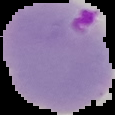

In [11]:
from PIL import Image
Image.open("cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_98.png")

In [12]:
import cv2
I = cv2.imread("cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_98.png")
print (I.shape)

(115, 115, 3)


In [13]:
from skimage import data_dir,io,color
path = "cell_images/Uninfected/*.png"
coll = io.ImageCollection(path)
print(len(coll))      #number of the pic
print(coll[3].shape)  # Images not in same size

13779
(124, 133, 3)


Image Prepocessing

In [0]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
img_rows = 100  
img_cols = 100 
num_classes = 10
nub_train = len(glob("cell_images/*/*.png"))
#Null array and then add pics' arrays
X = np.zeros((nub_train,img_rows,img_cols,3),dtype=np.uint8) 
y = np.zeros((nub_train,),dtype=np.uint8)

In [15]:
i = 0
for img_path in tqdm(glob("cell_images/*/*.png")):
  img = Image.open(img_path)
  img = img.resize((img_rows,img_cols)) #Pic resize
  arr = np.asarray(img)  #Pic to array
  X[i, :, :, :] = arr 

  if img_path.split('/')[1] == 'Uninfected':
    y[i] = 0  #Uninfected as 0
  else:
    y[i] = 1  #Parasitized as 1
        
  i += 1

100%|██████████| 27558/27558 [00:31<00:00, 881.89it/s]


In [0]:
y_10 = keras.utils.to_categorical(y, num_classes=2)

3.1 Start with a convolutional model without residual connections (using batch normalization is likely to be helpful and you should try it, whether you use dropout is your choice).

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_10, test_size=0.25, random_state=42)

In [0]:
#X_try = X_train[1:1000]
#y_try = y_train[1:1000]

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
input_shape = (img_rows, img_cols, 3)
num_classes = 2
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(num_classes, activation='softmax'))

In [20]:
cnn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
history_cnn = cnn.fit(X_train, y_train,
                      batch_size=128, epochs=10, verbose=1, validation_split=.1)

Train on 18601 samples, validate on 2067 samples
Epoch 1/10
18601/18601 [==============================] - 13s 694us/step - loss: 6.4164 - accuracy: 0.5222 - val_loss: 0.6769 - val_accuracy: 0.5781
Epoch 2/10
18601/18601 [==============================] - 6s 345us/step - loss: 0.6616 - accuracy: 0.5946 - val_loss: 0.6596 - val_accuracy: 0.6004
Epoch 3/10
18601/18601 [==============================] - 6s 347us/step - loss: 0.6352 - accuracy: 0.6191 - val_loss: 0.6482 - val_accuracy: 0.6105
Epoch 4/10
18601/18601 [==============================] - 6s 347us/step - loss: 0.6089 - accuracy: 0.6374 - val_loss: 0.6689 - val_accuracy: 0.6139
Epoch 5/10
18601/18601 [==============================] - 6s 347us/step - loss: 0.5255 - accuracy: 0.7146 - val_loss: 0.4042 - val_accuracy: 0.8403
Epoch 6/10
18601/18601 [==============================] - 6s 347us/step - loss: 0.2552 - accuracy: 0.9061 - val_loss: 0.2661 - val_accuracy: 0.8979
Epoch 7/10
18601/18601 [==============================] - 6s 3

In [21]:
cnn.evaluate(X_test, y_test)

6890/6890 [==============================] - 1s 216us/step


[0.2632937564991728, 0.9214804172515869]

In [0]:
def plot_history(logger, title): #function for plotting learning curve
    df = pd.DataFrame(logger.history)
    df[['accuracy', 'val_accuracy']].plot()
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    #df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
    #plt.ylabel("loss")

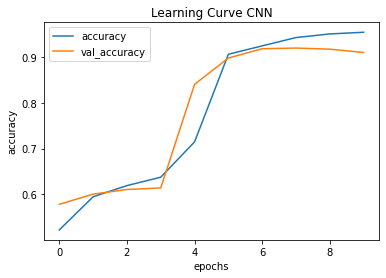

In [23]:
plot_history(history_cnn, "Learning Curve CNN")

Using batch normalization

In [0]:
from keras.layers import BatchNormalization #original model + batch normalization 
num_classes = 2
cnn_nom = Sequential()
cnn_nom.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_nom.add(BatchNormalization())
cnn_nom.add(MaxPooling2D(pool_size=(2, 2)))
cnn_nom.add(Conv2D(32, (3, 3), activation='relu'))
cnn_nom.add(BatchNormalization())
cnn_nom.add(MaxPooling2D(pool_size=(2, 2)))
cnn_nom.add(Flatten())
cnn_nom.add(Dense(64, activation='relu'))
cnn_nom.add(Dense(num_classes, activation='softmax'))

In [0]:
cnn_nom.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

In [26]:
history_cnn_nom = cnn_nom.fit(X_train, y_train,
                      batch_size=128, epochs=10, verbose=1, validation_split=.1)

Train on 18601 samples, validate on 2067 samples
Epoch 1/10
18601/18601 [==============================] - 20s 1ms/step - loss: 0.7223 - accuracy: 0.6766 - val_loss: 0.5513 - val_accuracy: 0.7615
Epoch 2/10
18601/18601 [==============================] - 19s 1ms/step - loss: 0.3199 - accuracy: 0.8823 - val_loss: 0.3344 - val_accuracy: 0.8670
Epoch 3/10
18601/18601 [==============================] - 19s 1ms/step - loss: 0.2451 - accuracy: 0.9117 - val_loss: 0.3612 - val_accuracy: 0.8495
Epoch 4/10
18601/18601 [==============================] - 19s 1ms/step - loss: 0.2059 - accuracy: 0.9246 - val_loss: 0.3377 - val_accuracy: 0.8592
Epoch 5/10
18601/18601 [==============================] - 19s 1ms/step - loss: 0.1894 - accuracy: 0.9306 - val_loss: 0.2431 - val_accuracy: 0.9071
Epoch 6/10
18601/18601 [==============================] - 19s 1ms/step - loss: 0.1603 - accuracy: 0.9420 - val_loss: 0.2485 - val_accuracy: 0.9192
Epoch 7/10
18601/18601 [==============================] - 19s 1ms/ste

In [27]:
cnn_nom.evaluate(X_test, y_test)

6890/6890 [==============================] - 2s 360us/step


[0.29773467659344693, 0.9217706918716431]

In [0]:
def plot_history(logger, title): #function for plotting learning curve
    df = pd.DataFrame(logger.history)
    df[['accuracy', 'val_accuracy']].plot()
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
    plt.ylabel("loss")

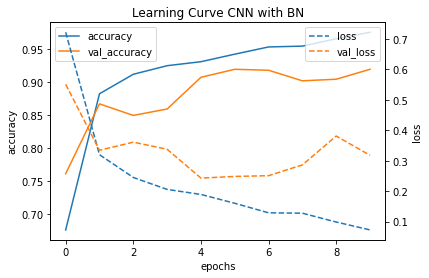

In [29]:
plot_history(history_cnn_nom, "Learning Curve CNN with BN")

Batch normalisation definitely improves the model, allowing for faster learning rate and better accuracies, however the validation was very unstable.

3.2 Augment the data using rotations, mirroring and possibly other transformations. How much can you improve your original model by data augmentation?

In [0]:
datagen = ImageDataGenerator( 
    featurewise_center=True, featurewise_std_normalization=True, 
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
    horizontal_flip=True, validation_split = .1)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

In [0]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.1) #making a validation set 

train_generator = datagen.flow(X_train2, y_train2, batch_size=128)
val_generator = datagen.flow(X_val, y_val, batch_size = 128) 

In [32]:
history_cnn_img2 = cnn_nom.fit_generator(train_generator, validation_data = val_generator, #added our own validation 
                    steps_per_epoch=len(X_train) / 128, epochs=10) 

Epoch 1/10
162/161 [==============================] - 55s 339ms/step - loss: 0.5533 - accuracy: 0.8172 - val_loss: 0.9653 - val_accuracy: 0.4925
Epoch 2/10
162/161 [==============================] - 53s 327ms/step - loss: 0.3250 - accuracy: 0.8726 - val_loss: 26.4562 - val_accuracy: 0.5070
Epoch 3/10
162/161 [==============================] - 53s 330ms/step - loss: 0.3045 - accuracy: 0.8829 - val_loss: 4.5286 - val_accuracy: 0.5985
Epoch 4/10
162/161 [==============================] - 53s 329ms/step - loss: 0.2782 - accuracy: 0.8938 - val_loss: 2.3857 - val_accuracy: 0.6497
Epoch 5/10
162/161 [==============================] - 53s 327ms/step - loss: 0.2741 - accuracy: 0.8987 - val_loss: 2.3741 - val_accuracy: 0.7334
Epoch 6/10
162/161 [==============================] - 53s 326ms/step - loss: 0.2595 - accuracy: 0.9041 - val_loss: 0.7520 - val_accuracy: 0.5254
Epoch 7/10
162/161 [==============================] - 54s 332ms/step - loss: 0.2439 - accuracy: 0.9135 - val_loss: 0.0928 - val_a

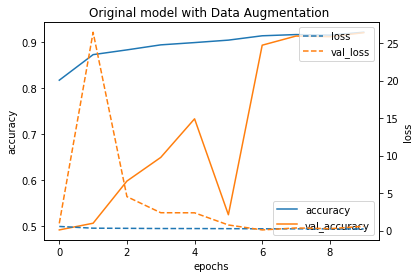

In [33]:
plot_history(history_cnn_img2, "Original model with Data Augmentation ") 

From the graph we can see that data augmentation does improve the results by making the validation accuracy more stable, even though the validation loss is still pretty unstable. The last epoch of the validation accuracy did improve by 0.01.

3.3 Build a deeper model using residual connections. Show that you can build a deep model that would not be able to learn if you remove the residual connections (i.e. compare a deep model with and without residual connections while the rest of the architecture is constant). Feel free to reuse existing architectures from the literature or use them as inspiration for your own. You can find commonly used architectures here: https://keras.io/applications/ However, the point of the exercise is to learn the weights from scratch, so please do not reuse the weights shipped with these applications.

In [0]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten 
from keras.models import Model
num_classes = 2
inputs = Input(shape=(img_rows, img_cols, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',padding='same')(inputs) 
conv1_2 = Conv2D(32, (3, 3), activation='relu',padding='same')(conv1_1) 
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2_1)
# add skip
skip2 = keras.layers.add([maxpool1, conv2_2])
maxpool2 = MaxPooling2D(pool_size=(2, 2))(skip2)
flat = Flatten()(maxpool2)
dense = Dense(64, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)


In [0]:
cnn_skipmodel = Model(inputs=inputs, outputs=predictions)
cnn_skipmodel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train, y_train, test_size = 0.2)

In [51]:
history_cnn_skip = cnn_skipmodel.fit(X_train, y_train,batch_size=128, epochs=10, verbose=1,validation_split=.1)


Train on 18601 samples, validate on 2067 samples
Epoch 1/10
18601/18601 [==============================] - 15s 790us/step - loss: 0.0274 - accuracy: 0.9931 - val_loss: 0.0626 - val_accuracy: 0.9792
Epoch 2/10
18601/18601 [==============================] - 14s 771us/step - loss: 0.0283 - accuracy: 0.9917 - val_loss: 0.0265 - val_accuracy: 0.9937
Epoch 3/10
18601/18601 [==============================] - 14s 770us/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0205 - val_accuracy: 0.9932
Epoch 4/10
18601/18601 [==============================] - 14s 771us/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0386 - val_accuracy: 0.9942
Epoch 5/10
18601/18601 [==============================] - 14s 773us/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0233 - val_accuracy: 0.9942
Epoch 6/10
18601/18601 [==============================] - 14s 772us/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0408 - val_accuracy: 0.9937
Epoch 7/10
18601/18601 [==============================] -

In [52]:
cnn_skipmodel.evaluate(X_test, y_test)

6890/6890 [==============================] - 3s 369us/step


[0.7574406550813668, 0.9377358555793762]

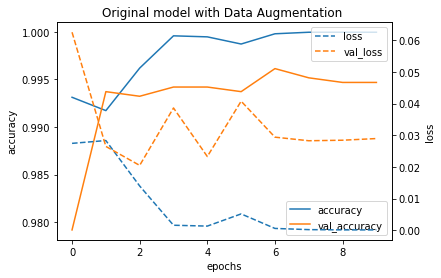

In [54]:
plot_history(history_cnn_skip, "Original model with Data Augmentation ") 

By using residual connections, the val_accuracy has increased steadily. The validation loss has some small fluctuation around 0.03.
Generally by adding residual connections, the model performance has increased greatly.